<a href="https://colab.research.google.com/github/BUSHUEVATATIANA/hh_project/blob/main/homeworks/hw09_poetry/assignment_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("{} device is available".format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-17 21:27:30--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-11-17 21:27:30 (7.26 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [251]:
tokens

['\n',
 ' ',
 '!',
 '(',
 ')',
 ',',
 '-',
 '.',
 '5',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '[',
 ']',
 '^',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '«',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '–',
 '—',
 '’',
 '…',
 '€',
 '<sos>']

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ["<sos>"]
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [326]:
# do not change the code in the block below
# __________start of block__________
batch_size = 100
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx["<sos>"]


def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size * seq_length - 1)
    data = np.array(
        text_encoded[start_index : start_index + batch_size * seq_length]
    ).reshape((batch_size, -1))
    yield np.hstack((start_column, data))


# __________end of block__________

Пример батча:

In [327]:
next(generate_chunk())

array([[83, 53, 56, ..., 52, 64,  1],
       [83, 76,  1, ..., 72, 54,  1],
       [83, 61, 76, ..., 56, 75, 46],
       ...,
       [83, 59, 58, ..., 46, 56, 50],
       [83, 49, 58, ..., 49, 45, 50],
       [83, 63,  7, ...,  1, 55, 59]])

In [350]:
len(text_encoded)

141888

In [347]:
gen = generate_chunk()
for c in gen:
  chunks = c
  chunks = c.reshape(-1,1)
  print(len(chunks))

10100


Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
# your beautiful experiments here

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

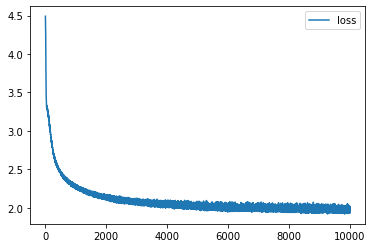

In [329]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [330]:
def random_chunk():
    start_index = random.randint(0, len(text_encoded) - 100)
    end_index = start_index + seq_length+ 1
    return text_encoded[start_index:end_index]

In [331]:
random_chunk()

[1,
 59,
 56,
 73,
 48,
 53,
 1,
 57,
 59,
 56,
 59,
 49,
 59,
 54,
 5,
 0,
 47,
 56,
 45,
 49,
 53,
 57,
 53,
 61,
 1,
 62,
 56,
 45,
 49,
 59,
 62,
 63,
 58,
 59,
 54,
 1,
 58,
 50,
 47,
 59,
 56,
 50,
 0,
 60,
 61,
 50,
 49,
 45,
 56,
 62,
 76,
 1,
 60,
 59,
 56,
 58,
 59,
 75,
 1,
 49,
 64,
 69,
 59,
 54,
 7,
 0,
 59,
 58,
 1,
 47,
 50,
 68,
 58,
 59,
 1,
 62,
 1,
 58,
 50,
 54,
 7,
 1,
 47,
 1,
 50,
 50,
 1,
 60,
 59,
 55,
 59,
 50,
 0,
 59,
 58,
 53,
 1,
 62,
 53,
 49,
 76]

In [332]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = tokens.index(str(string[c]))
    return tensor


In [333]:
 valid_size = (len(chunk) - 1) // batch_size * batch_size

    # Slice the chunk to make it divisible by batch_size
inp = torch.tensor(chunks[:valid_size],dtype=torch.int64).reshape((batch_size, -1))
target = torch.tensor(chunk[1:valid_size + 1], dtype=torch.int64).reshape((batch_size, -1))


In [334]:
def random_training_set():
    chunk = chunks

    # Slice the chunk to make it divisible by batch_size
    inp = torch.tensor(chunk[:-1])
    target = torch.tensor(chunk[1:])
    return inp, target

array([[83, 53, 60, ..., 73, 58, 59],
       [83, 54,  1, ..., 48, 53, 58],
       [83,  1, 60, ...,  1, 49, 64],
       ...,
       [83, 53, 49, ...,  1, 64, 51],
       [83, 45, 62, ...,  1, 47, 45],
       [83, 62,  1, ...,  1, 57, 50]])

In [293]:
random_training_set()[1].shape ==  random_training_set()[0].shape

True

In [343]:
def evaluate(prime_str='а', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = tokens[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [336]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(seq_length):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / seq_length

In [337]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [338]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(seq_length):
      if inp[c].nelement() == 0:
        print(f"Warning: inp[{c}] is empty, skipping this iteration.")
        continue  # Skip this iteration if the tensor is empty

      output, hidden = decoder(inp[c].long(), hidden)
      loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / seq_length

In [344]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(random_training_set()[0], random_training_set()[1])
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('дя', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 7s (100 5%) 0.0081]
дяечно,
в ее затеи не входил,
во всем ей веровал беспечно,
а са веровал беспечно,
а сам в халате ел и  

 14s (200 10%) 0.0026]
дяечно,
в ее затеи не входил,
во всем ей веровал беспечно,
а сам в халате ел и пил;
покойно жизнь ег е 

 21s (300 15%) 0.0014]
дяечно,
в ее затеи не входил,
во всем ей веровал беспечно,
а сам в халате ел и пил;
покойно жизнь ег е 

 28s (400 20%) 0.0009]
дяечно,
в ее затеи не входил,
во всем ей веровал беспечно,
а сам в халате ел и пил;
покойно жизнь ег е 

 35s (500 25%) 0.0006]
дяечно,
в ее затеи не входил,
во всем ей веровал беспечно,
а сам в халате ел и пил;
покойно жизнь ег е 

 42s (600 30%) 0.0005]
дяечно,
в ее затеи не входил,
во всем ей веровал беспечно,
а сам в халате ел и пил;
покойно жизнь ег е 

 49s (700 35%) 0.0004]
дяечно,
в ее затеи не входил,
во всем ей веровал беспечно,
а сам в халате ел и пил;
покойно жизнь ег е 

 56s (800 40%) 0.0003]
дяечно,
в ее затеи не входил,
во всем ей веровал беспечно,
а сам в халате ел и пил;

KeyboardInterrupt: 

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [308]:
def generate_sample(
    char_rnn, seed_phrase=None, max_length=100, temperature=1.0, device=device
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    if seed_phrase is not None:
        x_sequence = [token_to_idx["<sos>"]] + [
            token_to_idx[token] for token in seed_phrase
        ]
    else:
        x_sequence = [token_to_idx["<sos>"]]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any
    char_rnn.to(device)


    # your code here
    char_rnn.eval()

    # Prepare the initial hidden state for RNN
    h_state = None

    # Placeholder for the generated text
    generated_text = seed_phrase if seed_phrase else ""

    for _ in range(max_length - len(seed_phrase)):
        # Feed the input sequence to the RNN
        output, h_state = char_rnn(x_sequence[:, -1].view(1, 1), h_state)

        # Get the predicted token for the next character
        logits = output[-1, :]  # Get logits of the last token
        logits /= temperature  # Apply temperature scaling

        # Use softmax to get the probabilities for the next token
        probabilities = F.softmax(logits, dim=-1)

        # Sample a token based on the probability distribution
        token_idx = torch.multinomial(probabilities, 1).item()

        # Append the predicted token to the sequence
        x_sequence = torch.cat([x_sequence, torch.tensor([[token_idx]], dtype=torch.int64).to(device)], dim=1)

        # Convert the predicted token index to a character
        predicted_char = tokens[token_idx]  # Map index to character
        generated_text += predicted_char


    return "".join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [310]:
print(
    generate_sample(
        decoder, " мой дядя самых честных правил", max_length=100, temperature=0.8
    )
)

<sos> мой дядя самых честных правильный бег?
пора покинуть скучный брег
мне неприязненной стихии,
и среда


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = " мой дядя самых честных правил"

In [313]:
generated_phrases = [
 generate_sample(
        decoder,
        ' мой дядя самых честных правил',
         max_length=500,
         temperature=1.
     ).replace('<sos>', '')
     for _ in range(10)]

In [ ]:
generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [317]:
output = {key: ','.join([str(x) for x in list(generated_phrases.item()[key])]) for key in ['train', 'test']}

AttributeError: 'list' object has no attribute 'item'

In [318]:
# do not change the code in the block below
# __________start of block__________

if "generated_phrases" not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all(
        [x in set(tokens) for x in set(list(phrase))]
    ), "Unknown tokens detected, check your submission!"


submission_dict = {"token_to_idx": token_to_idx, "generated_phrases": generated_phrases}

np.save("submission_dict_hw09.npy", submission_dict, allow_pickle=True)
print("File saved to `submission_dict_hw09.npy`")
# __________end of block__________

File saved to `submission_dict_hw09.npy`


На этом задание завершено. Поздравляем!